In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pywt
from denoised_series import denoise_all_signal, plot_comparaison ,plot_comparaison2

df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])

outlier_dates = [pd.Timestamp('2001-09-11')]
df = df[~df['index'].isin(outlier_dates)]

df = df[(df['index'] >= '1988-01-01') & (df['index'] <= '2017-01-01')]

for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
df.set_index('index', inplace=True)
panel_data_df = df
panel_data_df

,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
index,,,,,
1988-01-04,187.50,193.50,198.25,200.00,202.75
1988-01-05,187.50,193.25,197.25,198.25,200.75
1988-01-06,191.00,195.75,199.75,201.75,204.50
1988-01-07,192.75,198.75,202.75,204.50,208.50
1988-01-08,192.50,198.00,202.00,203.50,207.25
...,...,...,...,...,...
2016-12-23,345.75,352.50,360.00,367.25,376.25
2016-12-27,355.00,361.25,368.50,375.75,384.25
2016-12-28,348.25,354.75,362.00,369.25,378.25


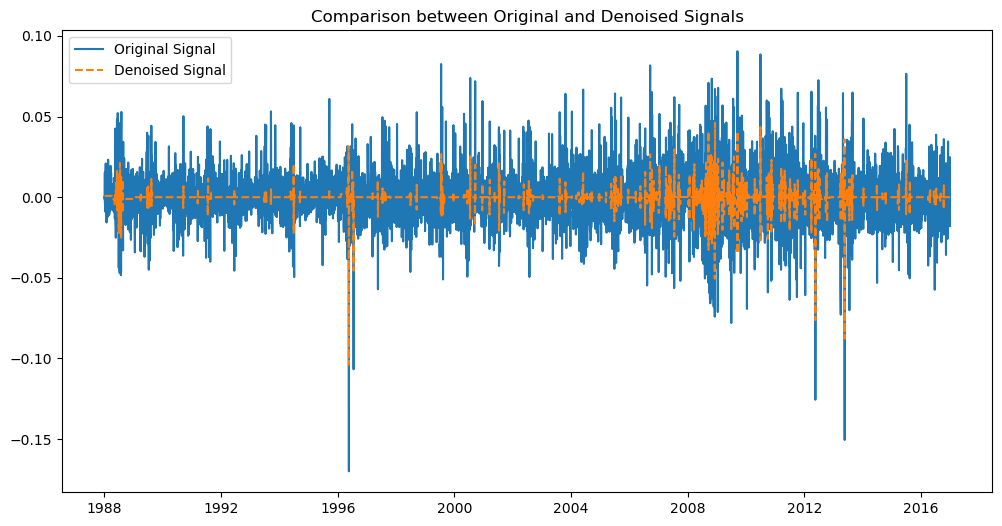

In [2]:
return_df = panel_data_df.pct_change(1).fillna(0)
signal = return_df.iloc[:,1]
wavelet='db1'
level = 0
# Découper la transformée en ondelettes
coeffs = pywt.wavedec(signal, wavelet, mode="per")

def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

# Calculer le seuil universel
sigma = madev(coeffs[level])/ 0.6745
#sigma = np.median(np.abs(coeffs[level])) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(len(signal)))

# Appliquer le seuil
coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
#coeffs[1:]= [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]

# Reconstruire le signal débruité
denoised_signal = pywt.waverec(coeffs_thresholded, wavelet, mode="per")
denoised_series = denoised_signal[:len(return_df)]  # Ajuster à la longueur originale si nécessaire
denoised_return_df = pd.DataFrame(denoised_series, index=return_df.index)

# Fonction pour afficher la comparaison entre le signal original et le signal débruité
def plot_comparison(original, denoised):
    plt.figure(figsize=(12, 6))
    plt.plot(original, label='Original Signal')
    plt.plot(denoised, label='Denoised Signal', linestyle='--')
    plt.title('Comparison between Original and Denoised Signals')
    plt.legend()
    plt.show()
    # Appel de la fonction de comparaison pour visualiser les résultats
plot_comparison(signal, denoised_return_df)

[0.031471130223324664, 0.05773773887874358, 0.06479522007507224, 0.0734906681101808, 0.08279823786224867, 0.08379861432440111, 0.07804127794378417, 0.08204500733629934, 0.08140531579634629, 0.07255004244690046, 0.07576116833537778, 0.07266284783737283, 0.07312292061073644]


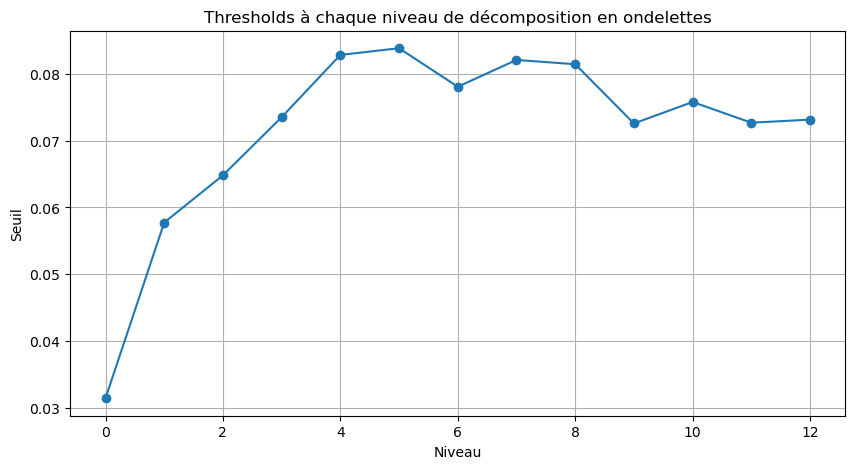

In [3]:
thresholds = []
for i in range(len(coeffs)):
    sigma = madev(coeffs[i])/ 0.6745
    #sigma = np.median(np.abs(coeffs[i])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    thresholds.append(threshold)
print(thresholds)
# Tracer les seuils
plt.figure(figsize=(10, 5))
plt.plot(thresholds, marker='o')
plt.title('Thresholds à chaque niveau de décomposition en ondelettes')
plt.xlabel('Niveau')
plt.ylabel('Seuil')
plt.grid(True)
plt.show()

In [9]:
denoised_return_df, prices_reconstructed_df =denoise_all_signal(panel_data_df, wavelet='db1',level = 0)

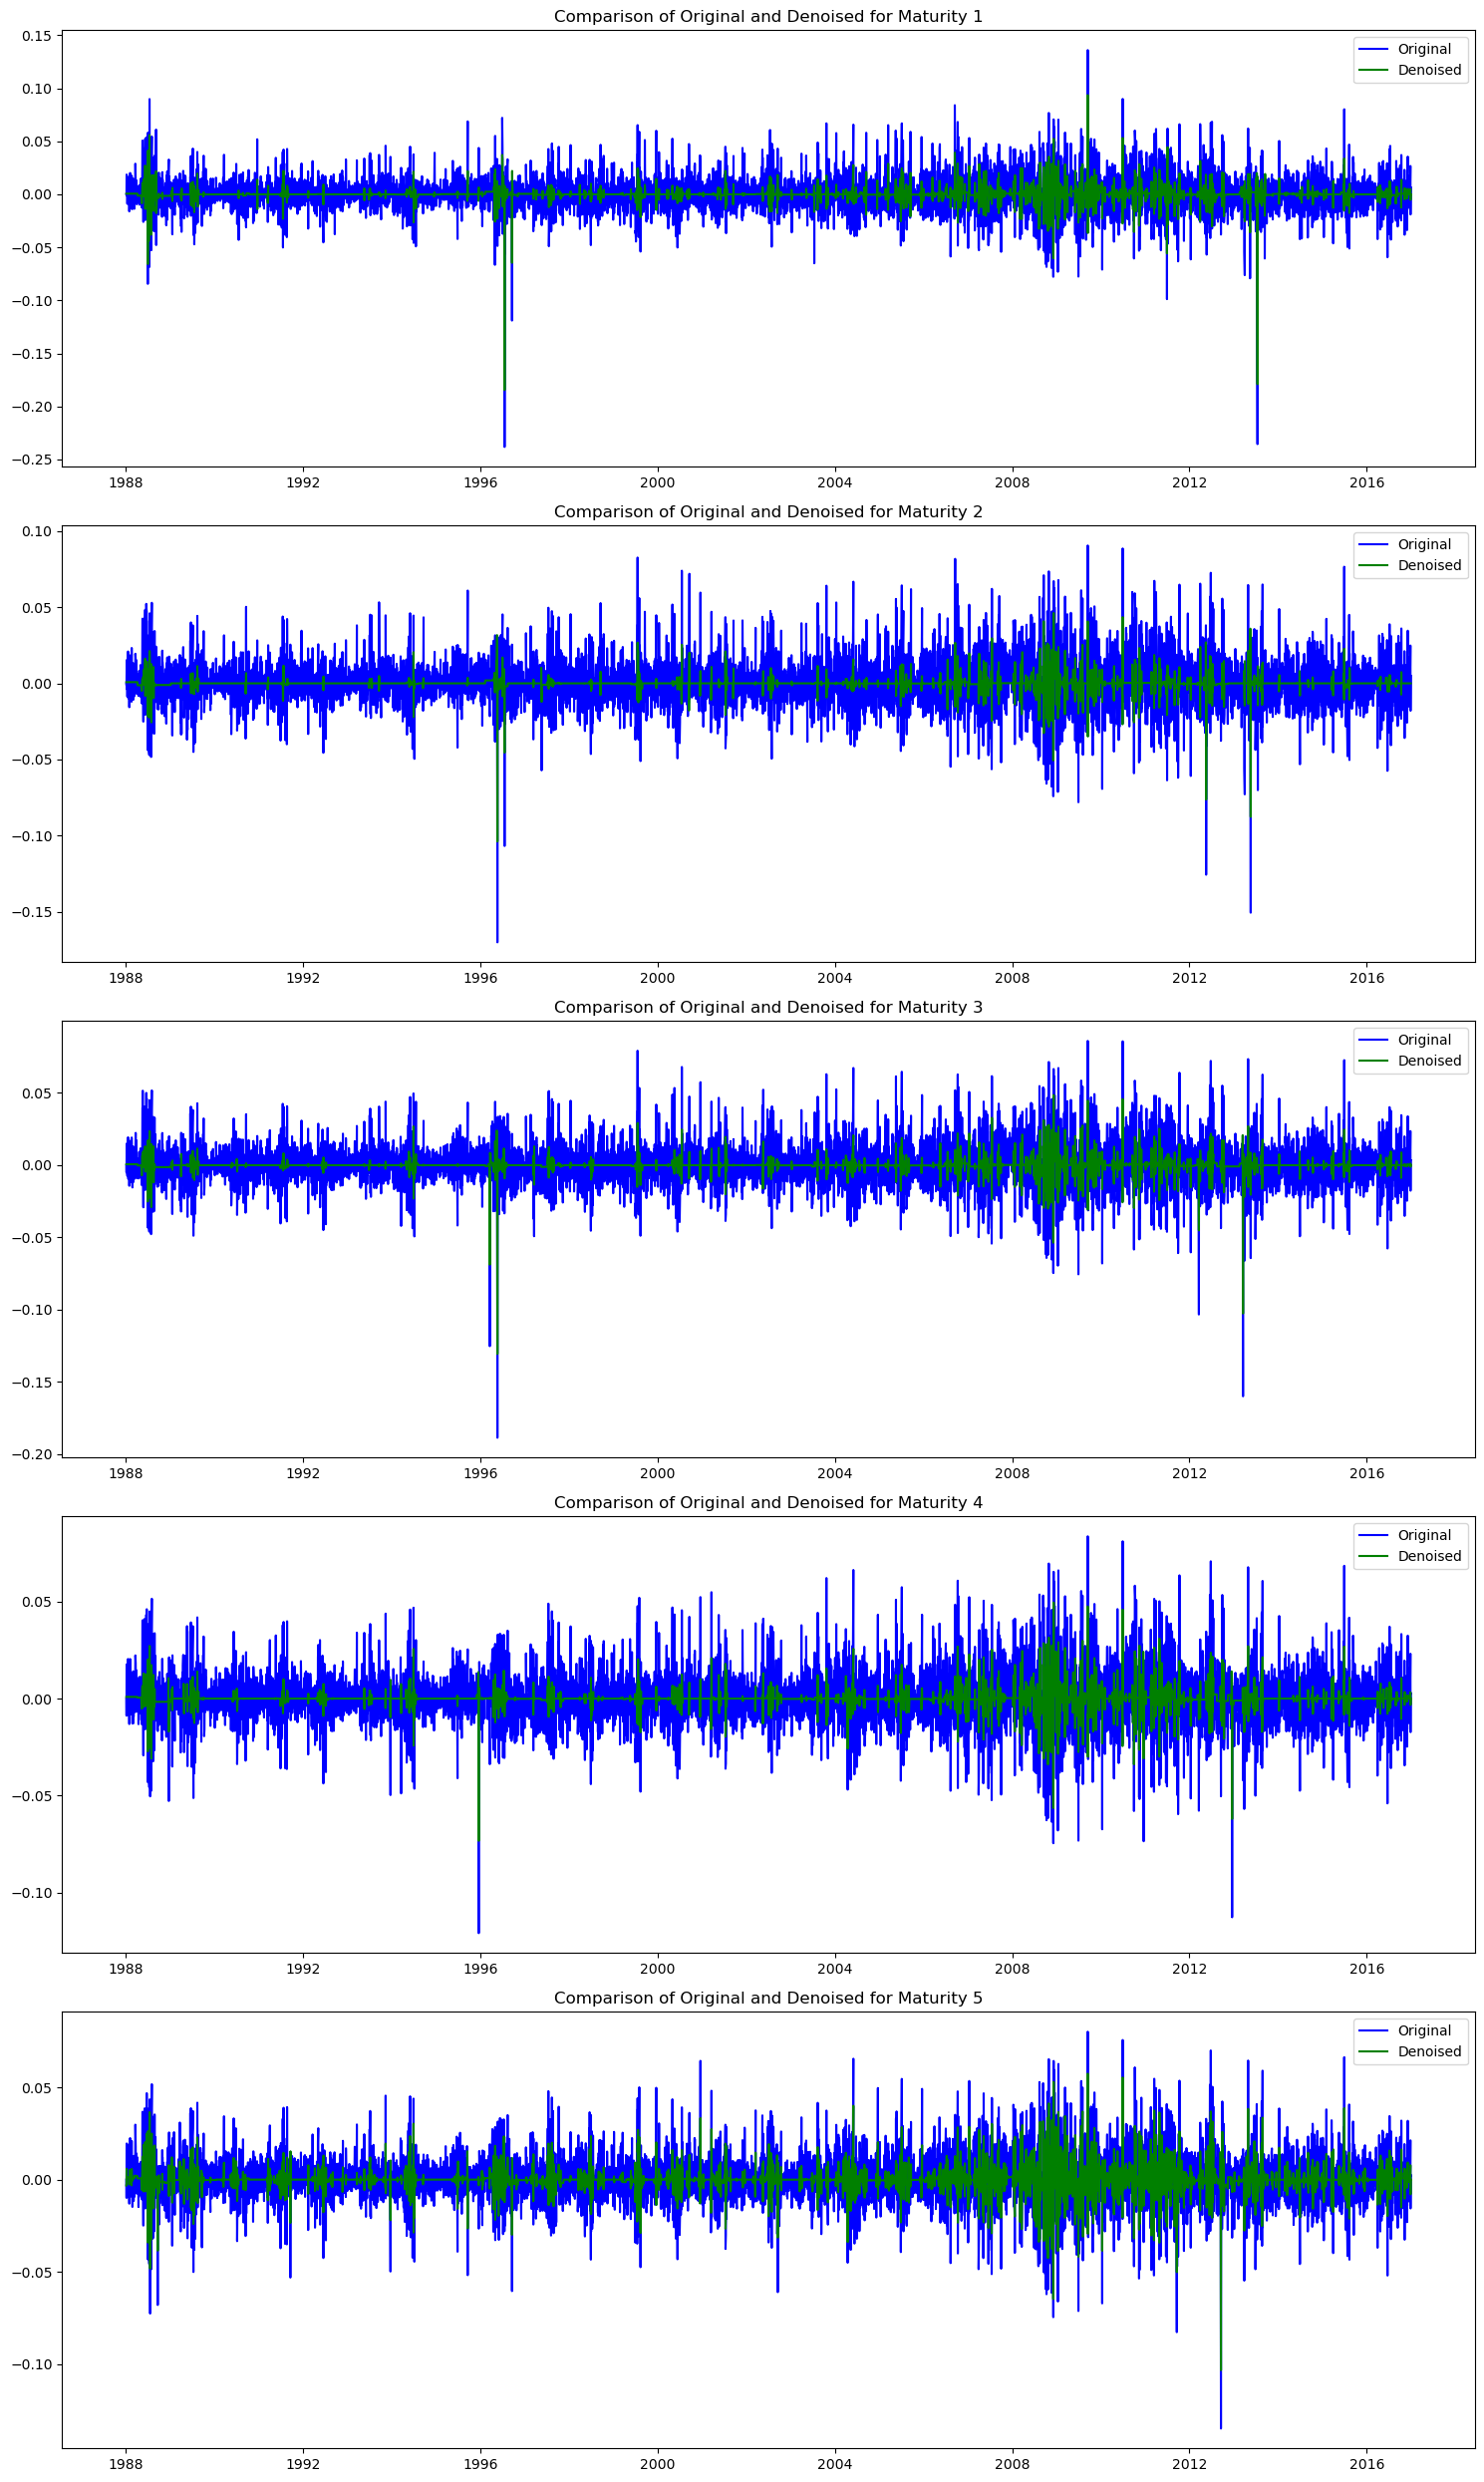

In [10]:
plot_comparaison(return_df, denoised_return_df)

#### Estimate coeffs of cyclical function

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Simuler des données avec moins de bruit et plus de points de données
np.random.seed(0)
t = np.linspace(1, 200, 400)  # Plus de points de données
data = {
    's_t': 3 * np.cos(2 * np.pi * t) + 2 * np.sin(2 * np.pi * t) +
           1.5 * np.cos(4 * np.pi * t) + 1 * np.sin(4 * np.pi * t) +
           np.random.normal(0, 0.25, 400)  # Moins de bruit
}
df = pd.DataFrame(data)

# Préparer les données pour la régression
df['cos_1t'] = np.cos(2 * np.pi * t)
df['sin_1t'] = np.sin(2 * np.pi * t)
df['cos_2t'] = np.cos(4 * np.pi * t)
df['sin_2t'] = np.sin(4 * np.pi * t)

# Régression linéaire
X = df[['cos_1t', 'sin_1t', 'cos_2t', 'sin_2t']]
#X = sm.add_constant(X)  # ajoute une constante
y = df['s_t']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                    s_t   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.338e+04
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        17:50:31   Log-Likelihood:                         -5.9343
No. Observations:                 400   AIC:                                      19.87
Df Residuals:                     396   BIC:                                      35.83
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [7]:
t = np.array(range(1, len(return_df) + 1))
# Préparer les données pour la régression
df = pd.DataFrame({
    'cos_1t': np.cos(2 * np.pi * t/ 200),
    'sin_1t': np.sin(2 * np.pi * t/ 200),
    'cos_2t': np.cos(4 * np.pi * t/ 200),
    'sin_2t': np.sin(4 * np.pi * t/ 200)
}, index=return_df.index) 

# Vérifier que les indices sont alignés
assert y.index.equals(X.index), "Les indices ne sont pas alignés!"

X = sm.add_constant(df)
y = return_df['Maturity 1']

# Exécuter la régression linéaire
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             Maturity 1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9947
Date:                Wed, 15 May 2024   Prob (F-statistic):              0.409
Time:                        17:50:31   Log-Likelihood:                 19401.
No. Observations:                7312   AIC:                        -3.879e+04
Df Residuals:                    7307   BIC:                        -3.876e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.165      0.2